# 2022-02-28 Low Rank

## Last time

* Solving least squares problems
* Geometry of the SVD

## Today

* Reflection on algorithm choices
* Low-rank structure
* Primer on interpolation

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2, aspect_ratio=:equal)
end

Aplot (generic function with 1 method)

# Condition number via SVD

$$ U \overbrace{\begin{bmatrix} \sigma_{\max} && \\ & \ddots & \\ && \sigma_{\min} \end{bmatrix}}^{\Sigma} V^T = A $$

\begin{align}
\lVert A \rVert &= \sigma_{\max} &
\kappa(A) &= \frac{\sigma_{\max}}{\sigma_{\min}} = \texttt{cond}(A)
\end{align}

In [46]:
A = randn(2,2) # nonsymmetric
A = A + A'

2×2 Matrix{Float64}:
  1.13519   -0.257307
 -0.257307   0.753558

svdvals(A) = [1.2647127088905932, 0.624033667117622]
norm(U - U') = 7.850462293418876e-17


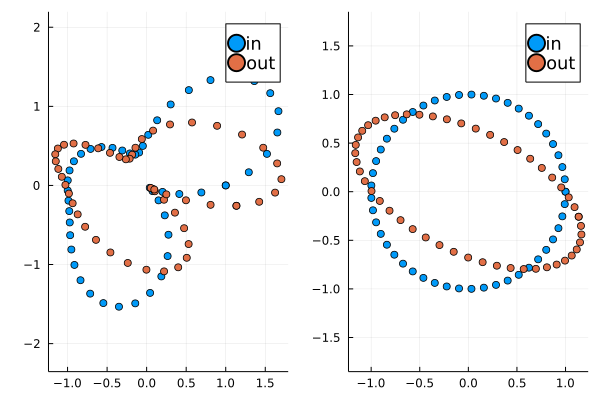

In [53]:
@show svdvals(A)
U, S, V = svd(A)
@show norm(U - U')
Aplot(A)

# Example: autonomous vehicles

* Need to solve least squares problems in real time
* Weight/cost/size increase with compute
* What algorithm to choose?
* What precision to use?

In [15]:
A = rand(5000, 500)
A_32 = Float32.(A)
@show cond(A)
@time qr(A);       # Householder; backward stable
@time qr_chol(A);  # Unstable
@time qr(A_32);

cond(A) = 56.62895367363473
  0.401766 seconds (7 allocations: 19.348 MiB)
  0.267054 seconds (10 allocations: 22.888 MiB)
  0.262063 seconds (7 allocations: 9.674 MiB)


In [55]:
V = vander(LinRange(-1, 1, 20))
Q, R = qr(Float32.(V))
@show norm(Q' * Q - I)
Q, R = qr_chol(V)
@show norm(Q' * Q - I)

norm(Q' * Q - I) = 1.422574f-6
norm(Q' * Q - I) = 0.7929497451834747


0.7929497451834747

# Best low rank approximation

The SVD can be truncated to yield the best rank-$k$ approximation of a matrix.

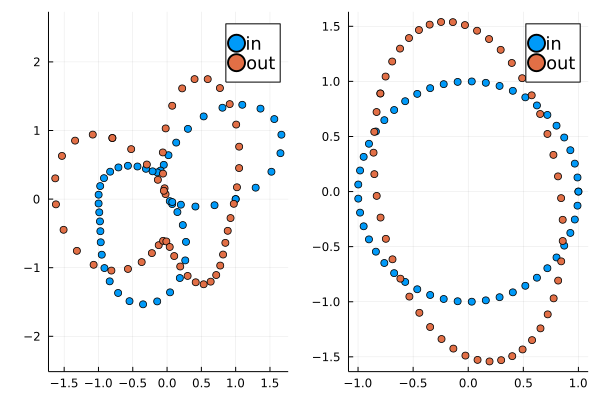

In [56]:
n, k = 2, 1
A = randn(n, n)
Aplot(A)

S[1:k + 1] = [1.5595652883771995, 0.8263763919470137]
norm(Ahat) = 1.559565288377199


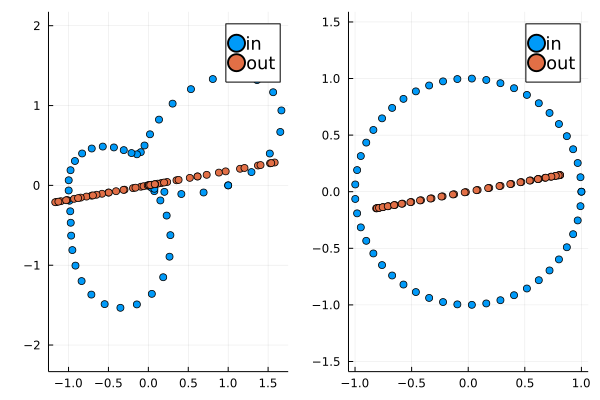

In [60]:
U, S, V = svd(A)
@show S[1:k+1]
Uhat = U[:, 1:k]
Shat = S[1:k]
Vhat = V[:, 1:k]
Ahat = Uhat * diagm(Shat) * Vhat'
@show norm(Ahat)
Aplot(Ahat - A)

# Example: Galaxies

Suppose we have two galaxies of size $n_1 = 100$ and $n_2 = 200$, each randomly distributed around their respective centers.

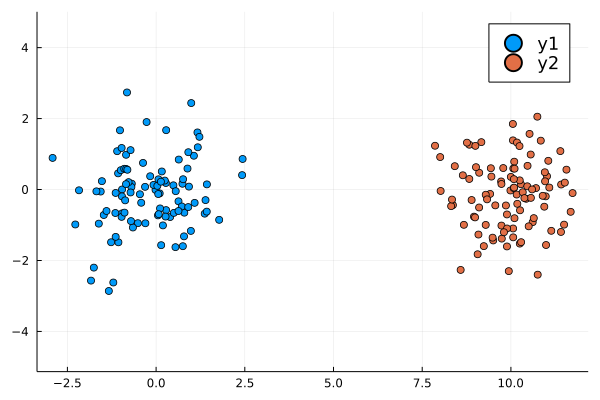

In [70]:
galaxy(center, sigma, n) = reshape(center, 1, 3) .+ sigma*randn(n, 3)
g1 = galaxy([0 0 0], 1, 100)
g2 = galaxy([10 0 0], 1, 100)

scatter(g1[:,1], g1[:,2], aspect_ratio=:equal)
scatter!(g2[:,1], g2[:,2])

## Forces between stars

Consider the gravitational force from a star at position $x_2$ acting on a star at position $x_1$,
$$ F_{1,2} = G \frac{m_1 m_2}{\lVert x_2 - x_1 \rVert^3} (x_2 - x_1) $$
where $m_1$ and $m_2$ are the masses of each star respectively.

In [34]:
function gravity(g1, g2)
    m = size(g1, 1)
    n = size(g2, 1)
    F = zeros(3*m, n)
    for i in 0:m-1
        for j in 1:n
            r = g2[j,:] - g1[1+i,:]
            F[1+3*i:3*(i+1),j] = r / norm(r)^3
        end
    end
    F
end
gravity(g1, g2)

300×200 Matrix{Float64}:
  0.00774771    0.00742588    0.00885278   …   0.00827471    0.00612012
 -0.000555126  -1.41668e-5   -0.00128975      -0.000192375  -0.000424015
 -0.000815177  -0.000124244  -0.00141273      -0.000347141   0.000162658
  0.00877027    0.00786987    0.0106905        0.00894689    0.00660422
  0.000877896   0.00132149    0.00040886       0.00139203    0.00053646
 -4.48706e-6    0.000703741  -0.000513661  …   0.000618362   0.000826044
  0.00971415    0.0083071     0.012377         0.00955195    0.00707152
  0.00204436    0.00232325    0.00191547       0.00261379    0.0012409
  0.000790051   0.00145803    0.000472912      0.00151998    0.00145083
  0.00947463    0.00836521    0.0117358        0.00957543    0.0069844
  0.00108515    0.00154438    0.000601652  …   0.00165472    0.00065026
  0.000308721   0.00104587   -0.00016147       0.00101583    0.00110748
  0.00995128    0.00880498    0.0123169        0.0101064     0.00727068
  ⋮                                   

# Spectrum

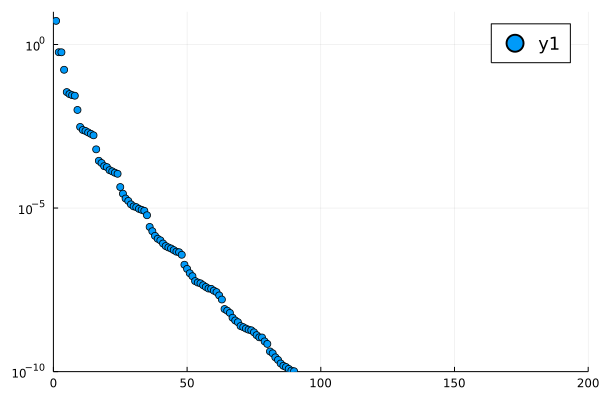

In [68]:
g1 = galaxy([0 0 0], 1, 500)
g2 = galaxy([10 0 0], 1, 500)
F = gravity(g1, g2)
U, S, V = svd(F)
scatter(S, yscale=:log10, ylims=(1e-10, 10), xlims=(0, 200))

In [66]:
k = 20
Uhat = U[:,1:k]
Shat = S[1:k]
Vhat = V[:,1:k]
Fhat = Uhat * diagm(Shat) * Vhat'
@show norm(F)
@show norm(F - Fhat)
size(F)

norm(F) = 2.5194440056980536
norm(F - Fhat) = 6.79544216333678e-5


(600, 300)

# What is interpolation?

Given data $(x_i, y_i)$, find a (smooth?) function $f(x)$ such that $f(x_i) = y_i$.

## Data in

* direct field observations/measurement of a physical or social system
* numerically processed observations, perhaps by applying physical principles
* output from an expensive "exact" numerical computation
* output from an approximate numerical computation

## Function out

* Polynomials
* Piecewise polynomials (includes nearest-neighbor)
* Powers and exponentials
* Trigonometric functions (sine and cosine)
* Neural networks

Interpolation fits the data exactly!

# Polynomial interpolation

We've seen how we can fit a polynomial using Vandermonde matrices, one column per basis function and one row per observation.

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| x^2 \Bigg| x^3 \Bigg]}_{A \in \mathbb R^{m\times n}} \Bigg[ \mathbf p \Bigg] = \Bigg[ \mathbf y \Bigg] $$

It's possible to find a unique polynomial $\mathbf p$ when which of the following are true?
1. $m \le n$
2. $m = n$
3. $m \ge n$

# Polynomial interpolation with a Vandermonde matrix

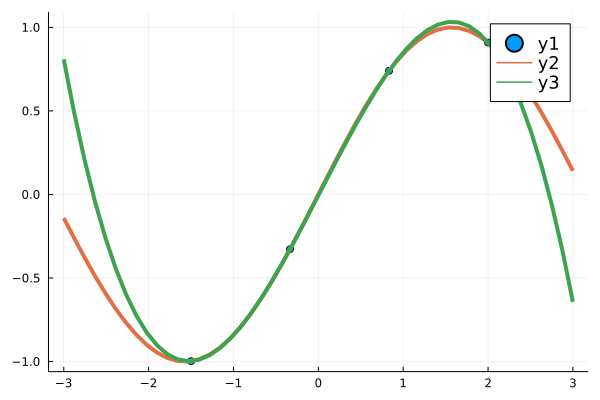

In [40]:
x = LinRange(-1.5, 2, 4)
y = sin.(x)
A = vander(x)
p = A \ y

scatter(x, y)
s = LinRange(-3, 3, 50)
plot!(s, [sin.(s) vander(s, length(p)) * p])

## Vandermonde matrices can be ill-conditioned

In [43]:
A = vander(LinRange(-1, 1, 30))
cond(A)

1.838577055392608e13

1. It's because of the points $x$?
2. It's because of the basis functions $\{ 1, x, x^2, x^3, \dotsc \}$?